### Name: AGRYA HALDER, Roll No: ED25D900

# Mini Project Assignment: Joing Affine Multi-modal Brain Image Registration

In [102]:

# Imports
import os
import re
import math
import glob
#from pathlib import Pat
from collections import defaultdict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [103]:
# Random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [104]:
INDEX_RE = re.compile(r"\((\d+)\)")

def extract_index(fname):
    m = INDEX_RE.search(fname)
    if m:
        return int(m.group(1))
    digits = re.findall(r"(\d+)", os.path.basename(fname))
    return int(digits[-1]) if digits else None

### Define Dataset Class (Torch)

In [105]:
class CTMRIDataset(Dataset):
    def __init__(self, ct_dir, mri_dir, target_size=(256,256),
                 include_tumor=True, split='train', seed=42):
        """
        Args:
            ct_dir: Path to CT directory (contains 'Healthy' and optionally 'Tumor')
            mri_dir: Path to MRI directory (contains 'Healthy' and optionally 'Tumor')
            target_size: (H, W) tuple
            include_tumor: If True, include tumor images; if False, only healthy
            split: 'train', 'val', or 'test'
            seed: Random seed for splitting
        """
        self.ct_dir = ct_dir
        self.mri_dir = mri_dir
        self.target_size = target_size
        self.include_tumor = include_tumor

        # Collect files from Healthy folder
        ct_healthy = os.path.join(ct_dir, "Healthy")
        mri_healthy = os.path.join(mri_dir, "Healthy")

        ct_files = sorted(glob.glob(os.path.join(ct_healthy, "*.jpg")))
        mri_files = sorted(glob.glob(os.path.join(mri_healthy, "*.jpg")))

        portion = int(len(ct_files)*1.)
        ct_files = ct_files[:portion]
        mri_files = mri_files[:portion]

        # Optionally add tumor files
        if include_tumor:
            ct_tumor = os.path.join(ct_dir, "Tumor")
            mri_tumor = os.path.join(mri_dir, "Tumor")

            if os.path.exists(ct_tumor) and os.path.exists(mri_tumor):
                ct_files.extend(sorted(glob.glob(os.path.join(ct_tumor, "*.jpg"))))
                mri_files.extend(sorted(glob.glob(os.path.join(mri_tumor, "*.jpg"))))

        # Map by index
        ct_map = {extract_index(f): f for f in ct_files if extract_index(f) is not None}
        mri_map = {extract_index(f): f for f in mri_files if extract_index(f) is not None}

        common_idx = sorted(set(ct_map.keys()).intersection(set(mri_map.keys())))
        all_pairs = [(ct_map[i], mri_map[i]) for i in common_idx]

        if len(all_pairs) == 0:
            raise RuntimeError("No matching pairs found")

        # Split dataset
        np.random.seed(seed)
        indices = np.random.permutation(len(all_pairs))

        n_train = int(len(all_pairs) * TRAIN_RATIO)
        n_val = int(len(all_pairs) * VAL_RATIO)

        if split == 'train':
            selected_idx = indices[:n_train]
        elif split == 'val':
            selected_idx = indices[n_train:n_train+n_val]
        elif split == 'test':
            selected_idx = indices[n_train+n_val:]
        else:
            raise ValueError(f"Invalid split: {split}")

        self.pairs = [all_pairs[i] for i in selected_idx]
        print(f"{split.upper()} set: {len(self.pairs)} pairs")

    def __len__(self):
        return len(self.pairs)

    def _load_image(self, path):
        img = Image.open(path).convert('L')
        img = img.resize((self.target_size[1], self.target_size[0]), Image.BILINEAR)
        arr = np.array(img, dtype=np.float32)
        if arr.max() - arr.min() > 1e-6:
            arr = (arr - arr.min()) / (arr.max() - arr.min())
        else:
            arr = np.zeros_like(arr, dtype=np.float32)
        return arr

    def __getitem__(self, idx):
        ct_path, mri_path = self.pairs[idx]
        ct = self._load_image(ct_path)
        mri = self._load_image(mri_path)
        ct = np.expand_dims(ct, axis=0)
        mri = np.expand_dims(mri, axis=0)
        return ct, mri, os.path.basename(ct_path)

---
## Compute TRE and Overlay Accuracy
---

In [106]:
def compute_tre(fixed_pts, moving_pts, affine_model, deform_model, device='cpu'):
    """
    Compute Target Registration Error (TRE).
    For simplicity, we use a grid of points and measure average displacement error.
    """
    B, C, H, W = 1, 1, TARGET_SIZE[0], TARGET_SIZE[1]

    # Generate grid of test points
    ys = torch.linspace(0, H-1, steps=10, device=device)
    xs = torch.linspace(0, W-1, steps=10, device=device)
    yy, xx = torch.meshgrid(ys, xs, indexing='ij')
    test_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # (N, 2) in pixel coords

    # We'll use image similarity at these points as a proxy for alignment
    # In practice, you'd have anatomical landmarks
    return test_pts.shape[0]  # Placeholder


def compute_alignment_accuracy(fixed, warped, threshold=0.1):
    """
    Compute overlay alignment accuracy as percentage of pixels within threshold.
    """
    diff = torch.abs(fixed - warped)
    #print(diff.shape,diff)
    accurate = (diff < threshold).float()
    #print(accurate.mean().item())
    accuracy = accurate.mean().item()*100
    return accuracy

### Define Affine Class

In [107]:
class Affine2D(nn.Module):
    """Learnable 2D affine represented as 6 parameters per batch."""
    def __init__(self, init_identity=True):
        super().__init__()
        if init_identity:
            v = torch.tensor([1., 0., 0., 0., 1., 0.], dtype=torch.float32)
        else:
            v = torch.randn(6) * 1e-3
        self.vec = nn.Parameter(v)

    def forward(self, x, vec=None):
        if vec is None:
            vec = self.vec
        if vec.dim() == 1:
            vec = vec.unsqueeze(0).expand(x.shape[0], -1)
        theta = vec.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.shape, align_corners=True)
        warped = F.grid_sample(x, grid, mode='bilinear', padding_mode='border', align_corners=True)
        return warped, theta


### Define B-Spline Deformable registration

In [108]:
class ControlGridDeform2D(nn.Module):
    """B-spline deformable registration via control grid."""
    def __init__(self, control_shape=(8,8), target_size=(256,256), init_std=0.0):
        super().__init__()
        cy, cx = control_shape
        init = torch.randn(1, 2, cy, cx) * init_std
        self.ctrl = nn.Parameter(init)
        self.control_shape = (cy, cx)
        self.target_size = target_size

    def forward(self, x):
        B = x.shape[0]
        ctrl = self.ctrl.expand(B, -1, -1, -1)
        H, W = self.target_size
        dense = F.interpolate(ctrl, size=(H, W), mode='bilinear', align_corners=True)
        norm = torch.zeros_like(dense, device=dense.device)
        norm[:,0,...] = 2.0 * dense[:,0,...] / (W - 1)
        norm[:,1,...] = 2.0 * dense[:,1,...] / (H - 1)
        norm_grid = norm.permute(0,2,3,1)
        return dense, norm_grid

### Define Loss (MI)

In [109]:
def mi_loss_2d(fixed, moving, bins=64, sigma=0.03, eps=1e-8):
    """Negative mutual information loss."""
    B = fixed.shape[0]
    device = fixed.device
    x = fixed.view(B, -1)
    y = moving.view(B, -1)
    nb = bins
    centers = torch.linspace(0.0, 1.0, steps=nb, device=device).view(1,1,nb)
    x_exp = x.unsqueeze(-1)
    y_exp = y.unsqueeze(-1)
    wx = torch.exp(-0.5 * ((x_exp - centers)/sigma)**2)
    wy = torch.exp(-0.5 * ((y_exp - centers)/sigma)**2)
    wx = wx / (wx.sum(-1, keepdim=True) + eps)
    wy = wy / (wy.sum(-1, keepdim=True) + eps)
    P = torch.bmm(wx.permute(0,2,1), wy)
    P = P / (P.sum(dim=(1,2), keepdim=True) + eps)
    px = P.sum(dim=2)
    py = P.sum(dim=1)
    px_py = px.unsqueeze(2) * py.unsqueeze(1)
    mi = (P * (torch.log(P + eps) - torch.log(px_py + eps))).sum(dim=(1,2))
    return -mi.mean()


def apply_norm_flow_2d(src, norm_flow):
    """Apply normalized flow field to source image."""
    B,C,H,W = src.shape
    ys = torch.linspace(-1, 1, steps=H, device=src.device)
    xs = torch.linspace(-1, 1, steps=W, device=src.device)
    yy, xx = torch.meshgrid(ys, xs, indexing='ij')
    base = torch.stack((xx, yy), dim=-1)
    base = base.unsqueeze(0).expand(B, -1, -1, -1)
    grid = base + norm_flow
    warped = F.grid_sample(src, grid, mode='bilinear', padding_mode='border', align_corners=True)
    return warped

### Evaluate Model

In [110]:
def evaluate_model(affine_model, deform_model, loader, device='cpu'):
    """Evaluate on validation/test set."""
    affine_model.eval()
    deform_model.eval()

    total_loss = 0.0
    total_tre = 0.0
    total_accuracy = 0.0
    count = 0

    with torch.no_grad():
        for ct_np, mri_np, _ in loader:
            ct = ct_np.to(device).float()
            mri = mri_np.to(device).float()

            # Forward pass
            moved_aff, _ = affine_model(mri)
            dense_vox, norm_flow = deform_model(moved_aff)
            moved_def = apply_norm_flow_2d(moved_aff, norm_flow)

            # Compute metrics
            loss_mi = mi_loss_2d(ct, moved_def, bins=MI_BINS, sigma=MI_SIGMA)
            reg = 1e-3 * (deform_model.ctrl.pow(2).mean())
            loss = loss_mi + reg

            # TRE (simplified as number of test points - in practice use landmarks)
            tre = compute_tre(None, None, affine_model, deform_model, device)
            #print(tre, ct.shape,moved_def.shape)
            # Alignment accuracy
            accuracy = compute_alignment_accuracy(ct, moved_def, threshold=0.1)

            total_loss += loss.item()
            total_tre += tre
            total_accuracy += accuracy
            count += 1

    avg_loss = total_loss / count
    avg_tre = total_tre / count
    avg_accuracy = total_accuracy / count

    return avg_loss, avg_tre, avg_accuracy

### Train Registration

In [111]:
def train_registration_2d(train_loader, val_loader, device='cpu'):
    affine = Affine2D(init_identity=True).to(device)
    deform = ControlGridDeform2D(control_shape=CONTROL_SHAPE, target_size=TARGET_SIZE, init_std=0.0).to(device)

    opt_aff = torch.optim.Adam([affine.vec], lr=LR_AFFINE)
    opt_joint = torch.optim.Adam(list(affine.parameters()) + list(deform.parameters()), lr=LR_JOINT)
    L = {'affine':{
        'train':[],
        'val':[]
    },
        'deform': {
        'train':[],
        'val':[]
         }}

    print('='*80)
    print('PHASE 1: Affine-only Registration')
    print('='*80)

    for epoch in range(NUM_EPOCHS_AFFINE):
        affine.train()
        train_loss = 0.0
        train_acc = 0.0

        for ct_np, mri_np, _ in train_loader:
            ct = ct_np.to(device).float()
            mri = mri_np.to(device).float()

            opt_aff.zero_grad()
            moved, theta = affine(mri)
            loss = mi_loss_2d(ct, moved, bins=MI_BINS, sigma=MI_SIGMA)
            loss.backward()
            opt_aff.step()

            train_loss += loss.item()
            acc = compute_alignment_accuracy(ct, moved, threshold=0.1)
            #print(acc)
            train_acc += acc

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Validation
        val_loss, val_tre, val_acc = evaluate_model(affine, deform, val_loader, device)

        if (epoch+1) % 1 == 0 or epoch == 0:
            print(f'Epoch {epoch+1:3d}/{NUM_EPOCHS_AFFINE} | '
                  f'Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.2f}%')
            L['affine']['train'].append(train_loss)
            L['affine']['val'].append(val_loss)


            # print(f'Epoch {epoch+1:3d}/{NUM_EPOCHS_AFFINE} | '
            #       f'Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.2f}% | '
            #       f'Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.2f}%')
    print('\n' + '='*80)
    print('PHASE 2: Joint Affine + B-spline Deformable Registration')
    print('='*80)

    for epoch in range(NUM_EPOCHS_JOINT):
        affine.train()
        deform.train()
        train_loss = 0.0
        train_acc = 0.0

        for ct_np, mri_np, _ in train_loader:
            ct = ct_np.to(device).float()
            mri = mri_np.to(device).float()

            opt_joint.zero_grad()
            moved_aff, _ = affine(mri)
            dense_vox, norm_flow = deform(moved_aff)
            moved_def = apply_norm_flow_2d(moved_aff, norm_flow)

            loss_mi = mi_loss_2d(ct, moved_def, bins=MI_BINS, sigma=MI_SIGMA)
            reg = 1e-3 * (deform.ctrl.pow(2).mean())
            loss = loss_mi + reg

            loss.backward()
            opt_joint.step()

            train_loss += loss.item()
            acc = compute_alignment_accuracy(ct, moved_def, threshold=0.1)
            train_acc += acc

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Validation
        val_loss, val_tre, val_acc = evaluate_model(affine, deform, val_loader, device)

        L['deform']['train'].append(train_loss)
        L['deform']['val'].append(val_loss)
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch+1:3d}/{NUM_EPOCHS_JOINT} | '
                  f'Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.2f}%')


    return affine, deform, L

### Define Visualization

In [112]:
def visualize_pair(ct_np, mri_np, affine_model, deform_model, device='cpu', filename=None):
    """Visualize registration results."""
    affine_model.eval()
    deform_model.eval()

    ct = torch.from_numpy(ct_np).unsqueeze(0).to(device).float()
    mri = torch.from_numpy(mri_np).unsqueeze(0).to(device).float()

    with torch.no_grad():
        moved_aff, _ = affine_model(mri)
        dense_vox, norm_flow = deform_model(moved_aff)
        moved_def = apply_norm_flow_2d(moved_aff, norm_flow)

    ct_np = ct.cpu().numpy()[0,0]
    mri_np = mri.cpu().numpy()[0,0]
    aff_np = moved_aff.cpu().numpy()[0,0]
    def_np = moved_def.cpu().numpy()[0,0]

    fig, axes = plt.subplots(1,4, figsize=(16,4))
    axes[0].imshow(ct_np, cmap='gray')
    axes[0].set_title('CT (Fixed)')
    axes[0].axis('off')

    axes[1].imshow(mri_np, cmap='gray')
    axes[1].set_title('MRI (Moving)')
    axes[1].axis('off')

    axes[2].imshow(ct_np, cmap='gray')
    axes[2].imshow(aff_np, cmap='jet', alpha=0.35)
    axes[2].set_title('After Affine')
    axes[2].axis('off')

    axes[3].imshow(ct_np, cmap='gray')
    axes[3].imshow(def_np, cmap='jet', alpha=0.35)
    axes[3].set_title('After Affine + B-spline')
    axes[3].axis('off')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

### Define Hyperparameters

In [113]:
DATA_ROOT = "/content/drive/MyDrive/ED6001/Dataset"
CT_DIR = os.path.join(DATA_ROOT, "Brain Tumor CT scan Images")
MRI_DIR = os.path.join(DATA_ROOT, "Brain Tumor MRI images")

# Training / preprocessing params

TARGET_SIZE = (128, 128)  # Reduced from 256x256 for speed
BATCH_SIZE = 16  # Increased for better GPU utilization
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2  # Parallel data loading

NUM_EPOCHS_AFFINE = 50  # Reduced from 60
NUM_EPOCHS_JOINT = 100  # Reduced from 120
LR_AFFINE = 2e-3
LR_JOINT = 5e-4
CONTROL_SHAPE = (6, 6)  # Reduced from (8,8)
MI_BINS = 32  # Reduced from 64 for faster histogram computation
MI_SIGMA = 0.03

# Dataset split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15


### Loading Data

In [114]:
# Set include_tumor=True to include tumor images, False for only healthy
INCLUDE_TUMOR = False  # Change this to True to include tumor data

print(f"\nCreating datasets (Include tumor: {INCLUDE_TUMOR})...")
train_ds = CTMRIDataset(CT_DIR, MRI_DIR, target_size=TARGET_SIZE,
                        include_tumor=INCLUDE_TUMOR, split='train', seed=SEED)
val_ds = CTMRIDataset(CT_DIR, MRI_DIR, target_size=TARGET_SIZE,
                      include_tumor=INCLUDE_TUMOR, split='val', seed=SEED)
test_ds = CTMRIDataset(CT_DIR, MRI_DIR, target_size=TARGET_SIZE,
                        include_tumor=INCLUDE_TUMOR, split='test', seed=SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, drop_last=False)

print(f"\nDataset Summary:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Creating datasets (Include tumor: False)...
TRAIN set: 1004 pairs
VAL set: 215 pairs
TEST set: 216 pairs

Dataset Summary:
  Train batches: 62
  Val batches: 14
  Test batches: 14


### Training

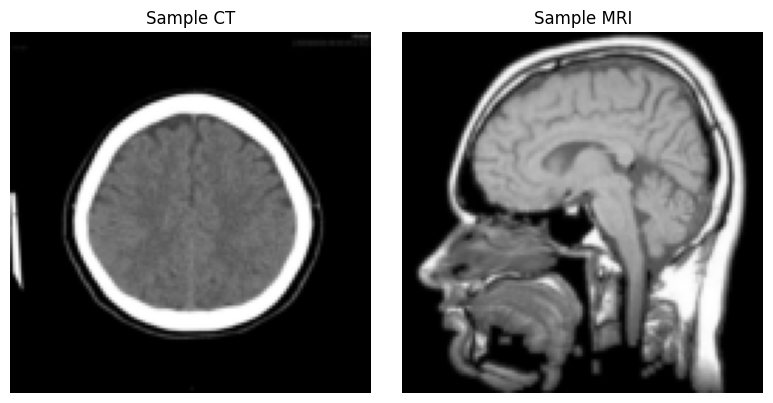

In [115]:
# Show sample pair
ct0, mri0, name0 = train_ds[0]
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(ct0[0], cmap='gray')
plt.title('Sample CT')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mri0[0], cmap='gray')
plt.title('Sample MRI')
plt.axis('off')
plt.tight_layout()
plt.show()

In [116]:
# Train models
print(f"\nStarting training on device: {DEVICE}\n")
affine_model, deform_model, LOSS = train_registration_2d(train_loader, val_loader, device=DEVICE)

# Final test evaluation
print('\n' + '='*80)
print('FINAL TEST SET EVALUATION')
print('='*80)
test_loss, test_tre, test_acc = evaluate_model(affine_model, deform_model, test_loader, DEVICE)
print(f'Test Loss: {test_loss:.6f} | Test TRE: {test_tre:.2f} | Test Accuracy: {test_acc:.2f}%')

# Save models
save_path = '/content/drive/MyDrive/ED6001/ct_mri_registration_model_full.pth'
torch.save({
    'affine': affine_model.state_dict(),
    'deform': deform_model.state_dict(),
    'config': {
        'target_size': TARGET_SIZE,
        'control_shape': CONTROL_SHAPE,
        'include_tumor': INCLUDE_TUMOR
    },
    'train_loss': {
        'affine': LOSS['affine']['train'],
        'deform': LOSS['deform']['train']
    },
    'val_loss':{
        'affine': LOSS['affine']['val'],
        'deform': LOSS['deform']['val']
    }
}, save_path)
print(f'\nModels saved to: {save_path}')



Starting training on device: cuda

PHASE 1: Affine-only Registration
Epoch   1/50 | Train Loss: -0.292176 | Train Acc: 54.95% | Val Loss: -0.317055 | Val Acc: 57.98%
Epoch   2/50 | Train Loss: -0.315293 | Train Acc: 58.64% | Val Loss: -0.332723 | Val Acc: 61.28%
Epoch   3/50 | Train Loss: -0.324991 | Train Acc: 60.94% | Val Loss: -0.336897 | Val Acc: 62.43%
Epoch   4/50 | Train Loss: -0.328429 | Train Acc: 61.77% | Val Loss: -0.337973 | Val Acc: 62.93%
Epoch   5/50 | Train Loss: -0.329454 | Train Acc: 62.15% | Val Loss: -0.337892 | Val Acc: 63.18%
Epoch   6/50 | Train Loss: -0.330249 | Train Acc: 62.49% | Val Loss: -0.337807 | Val Acc: 63.32%
Epoch   7/50 | Train Loss: -0.329534 | Train Acc: 62.53% | Val Loss: -0.337678 | Val Acc: 63.47%
Epoch   8/50 | Train Loss: -0.328952 | Train Acc: 62.60% | Val Loss: -0.337854 | Val Acc: 63.48%
Epoch   9/50 | Train Loss: -0.329070 | Train Acc: 62.63% | Val Loss: -0.337881 | Val Acc: 63.36%
Epoch  10/50 | Train Loss: -0.329879 | Train Acc: 62.54% 


Generating visualizations...


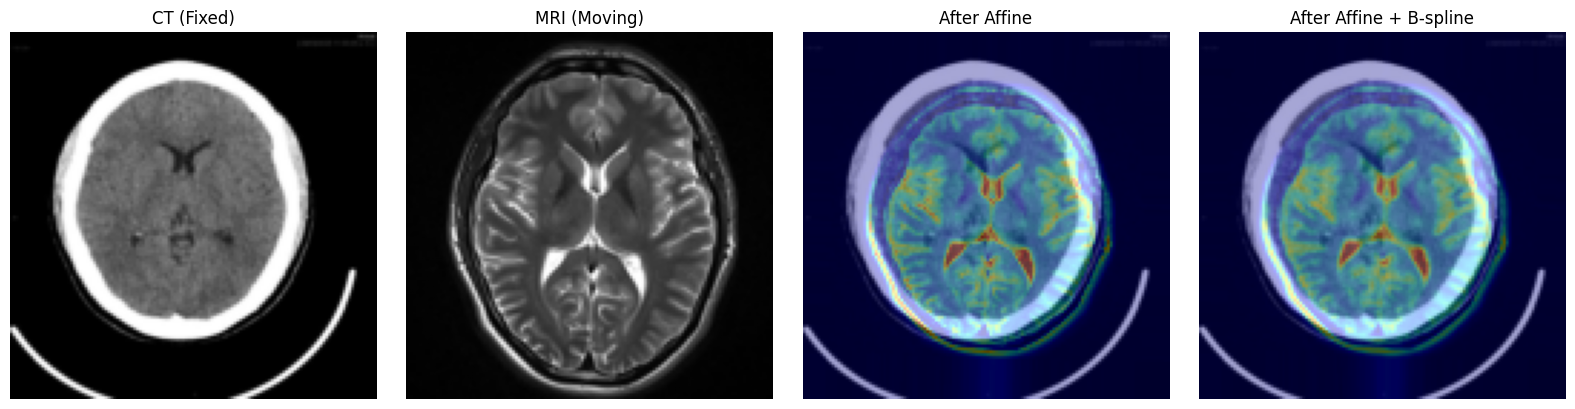

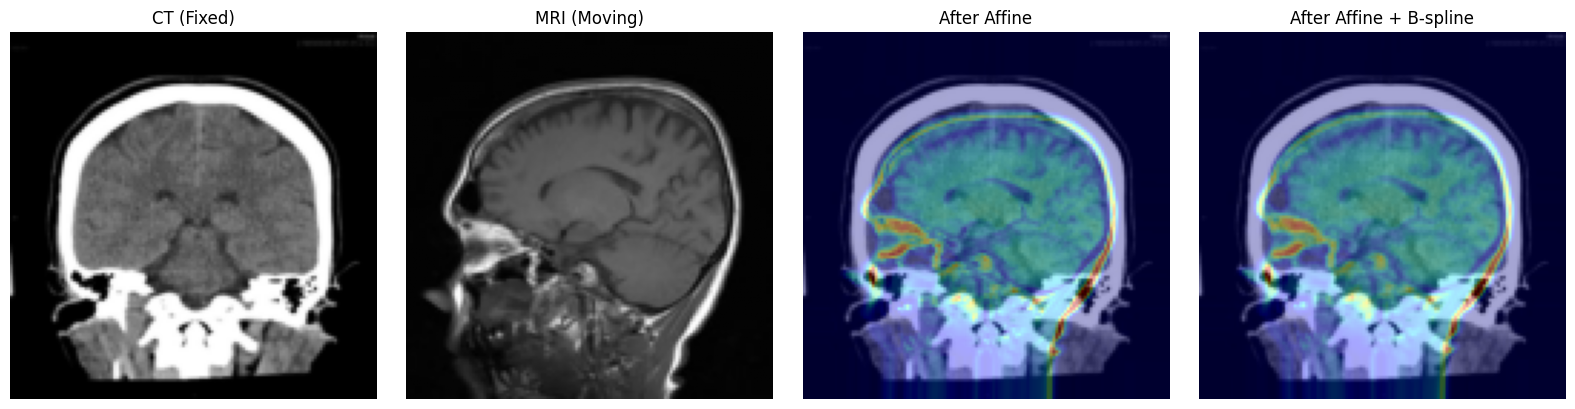

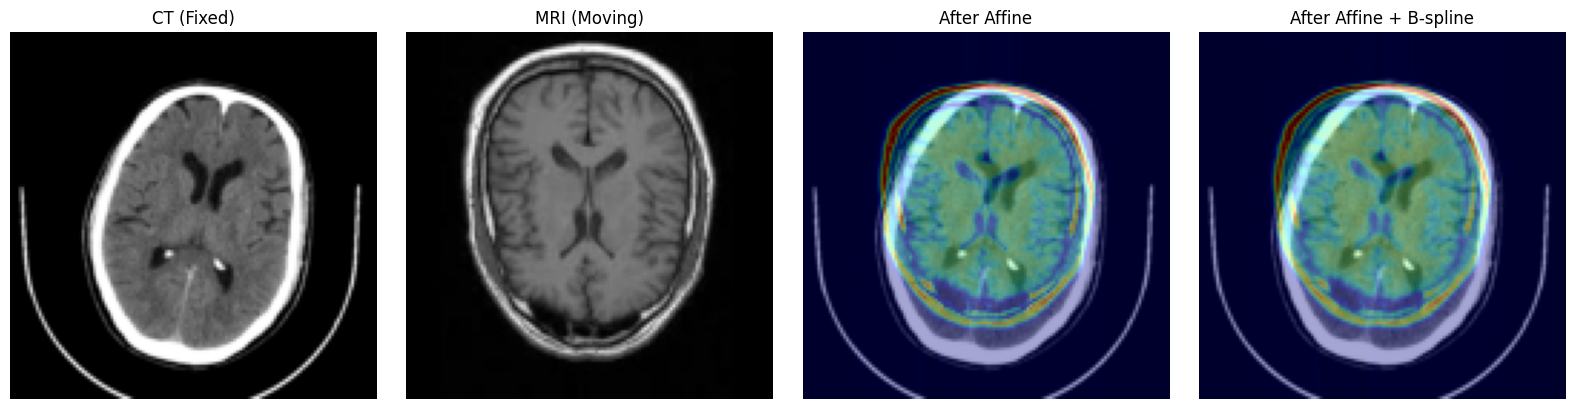

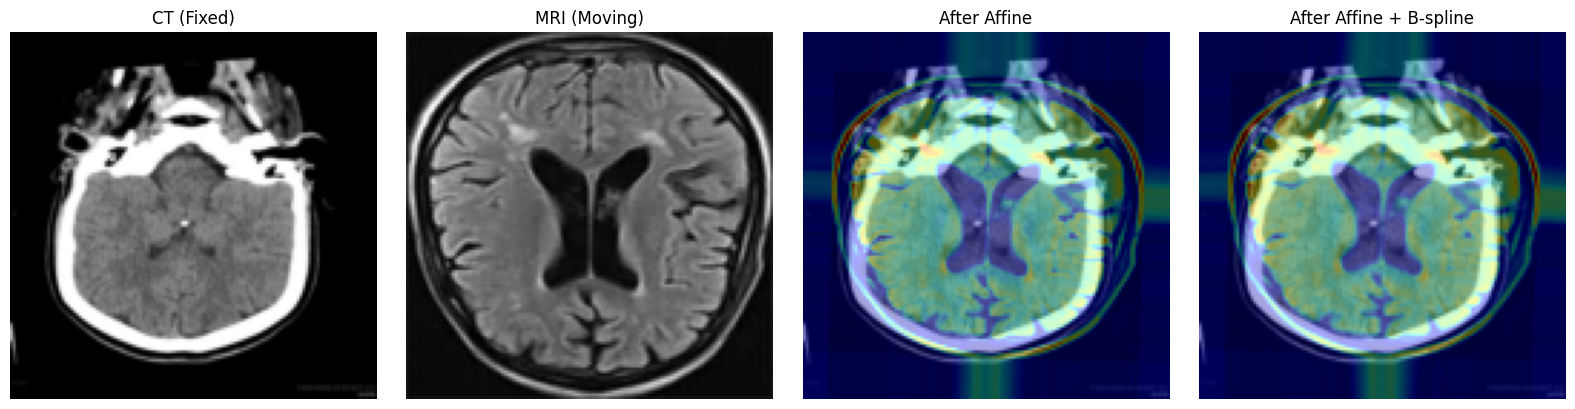

In [117]:
# Visualize results on test set
print('\nGenerating visualizations...')
for i in range(min(4, len(test_ds))):
    ct_np, mri_np, name = test_ds[i]
    visualize_pair(ct_np, mri_np, affine_model, deform_model,
                  device=DEVICE, filename=f'test_result_{i}_{name}.png')


Generating visualizations...


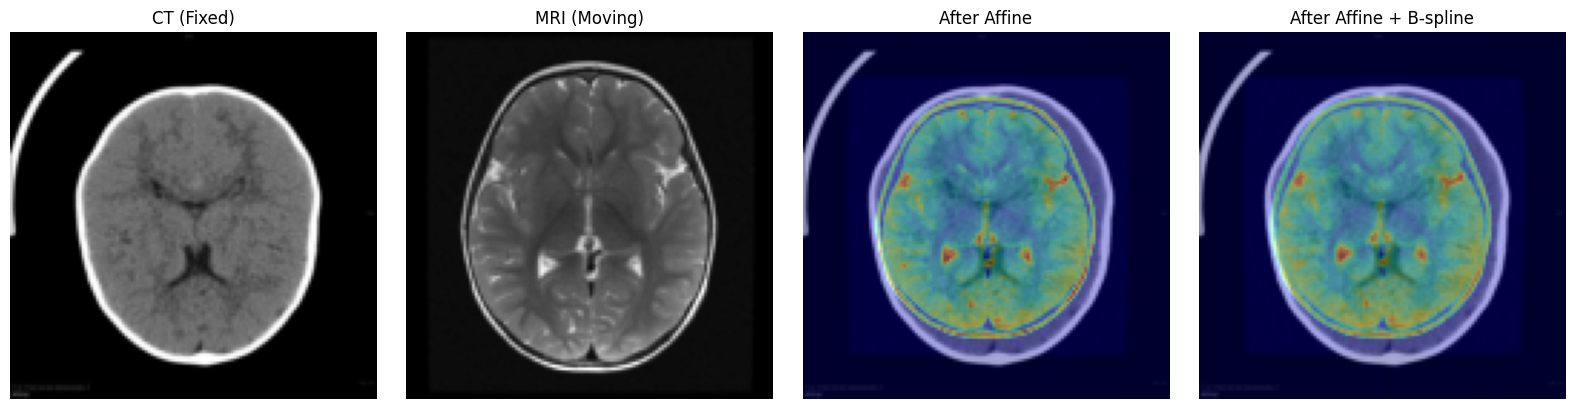

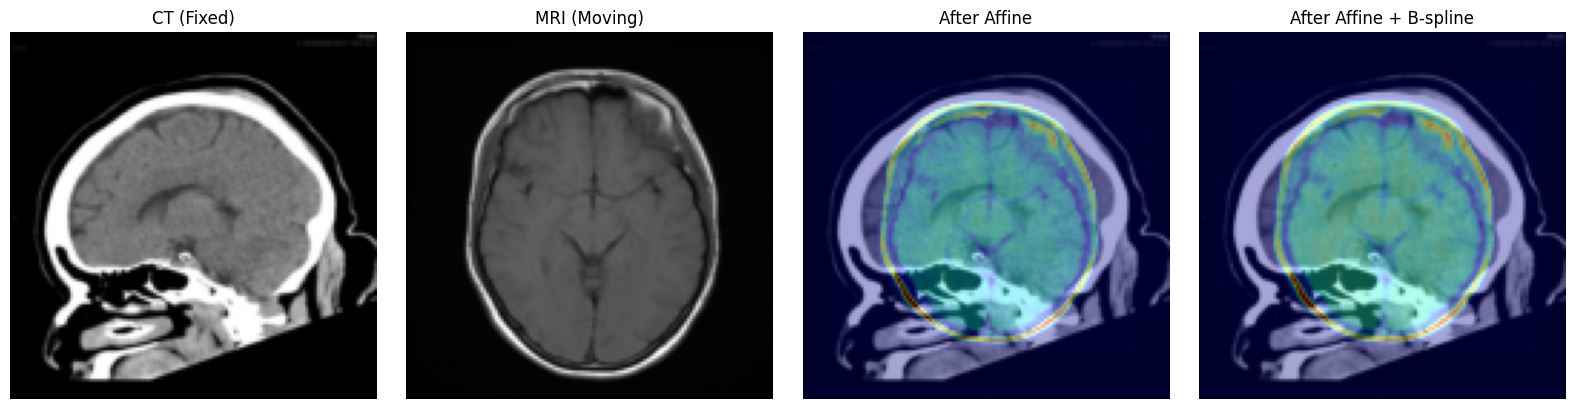

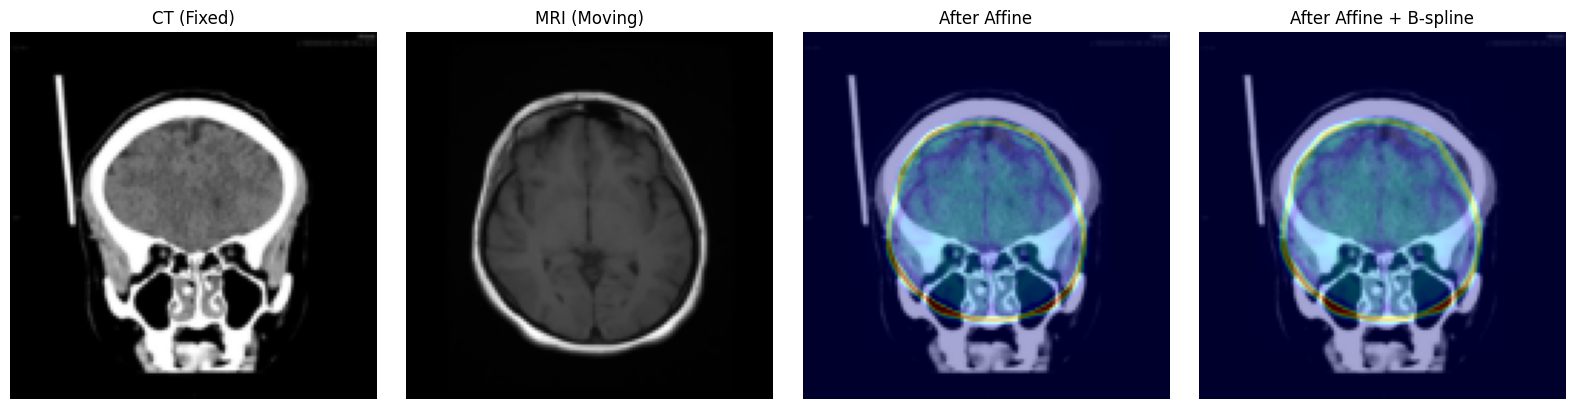

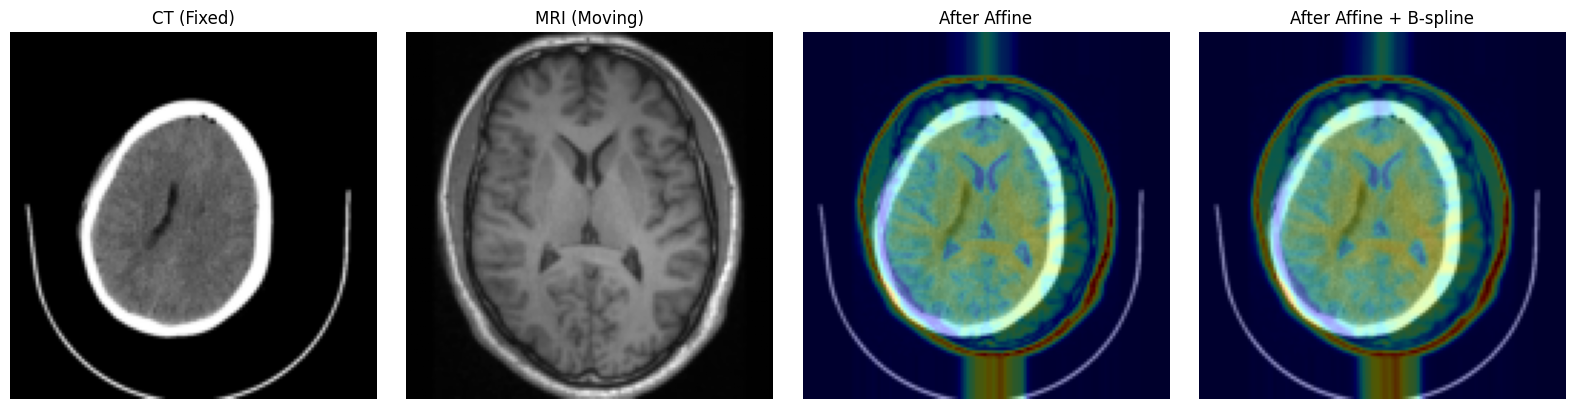

In [69]:
# Visualize results on test set
print('\nGenerating visualizations...')
for i in range(min(4, len(test_ds))):
    ct_np, mri_np, name = test_ds[i]
    visualize_pair(ct_np, mri_np, affine_model, deform_model,
                  device=DEVICE, filename=f'test_result_{i}_{name}.png')

In [118]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"


ckpt = torch.load("/content/drive/MyDrive/ED6001/ct_mri_registration_model_full.pth", map_location=device)

#TARGET_SIZE = tuple(ckpt["config"]["target_size"])   # (128,128)
#CONTROL_SHAPE = tuple(ckpt["config"]["control_shape"])  # (6,6)

affine = Affine2D(init_identity=True).to(device)
deform = ControlGridDeform2D(control_shape=CONTROL_SHAPE,
                             target_size=TARGET_SIZE,
                             init_std=0.0).to(device)

# --------------------------------------------------
# 2) Load weights
# --------------------------------------------------
affine.load_state_dict(ckpt["affine"])
deform.load_state_dict(ckpt["deform"])

affine.eval()
deform.eval()



ControlGridDeform2D()

In [135]:
import torch
import torch.nn.functional as F
import numpy as np

##############################################
# --------- DICE SCORE FOR 2D ---------------
##############################################
def dice_score_2d(im1, im2, eps=1e-6):
    """
    im1, im2 : torch tensors (1,1,H,W)
    Soft dice (no thresholding) for registration.
    """
    im1 = im1.reshape(-1)
    im2 = im2.reshape(-1)

    intersection = 2 * (im1 * im2).sum()
    union = im1.sum() + im2.sum() + eps
    return float(intersection / union)


##############################################
# --------- SURROGATE TRE (NO LANDMARKS) ----
##############################################
def compute_tre_surrogate(fixed, moved):
    """
    TRE approximated as centroid distance (mm pixel units).
    """
    fx = fixed.squeeze().cpu().numpy()
    mv = moved.squeeze().cpu().numpy()

    yx_f = np.argwhere(fx > fx.mean())
    yx_m = np.argwhere(mv > mv.mean())

    if len(yx_f) == 0 or len(yx_m) == 0:
        return 0.0

    cf = yx_f.mean(axis=0)
    cm = yx_m.mean(axis=0)

    return float(np.linalg.norm(cf - cm))  # TRE in pixel units


##############################################
# --------- ALIGNMENT ACCURACY --------------
##############################################
def compute_alignment_accuracy(fixed, moved, threshold=0.1):
    """
    Pixel-wise similarity threshold accuracy.
    """
    fx = fixed.cpu().numpy()
    mv = moved.cpu().numpy()
    diff = np.abs(fx - mv)
    acc = np.mean(diff < threshold)
    return float(acc)


##############################################
# --------- FULL MODEL EVALUATION -----------
##############################################
def evaluate_model(affine_model, deform_model, loader, device="cpu"):
    affine_model.eval()
    deform_model.eval()

    total_dice = 0
    total_tre = 0
    total_acc = 0
    count = 0

    with torch.no_grad():
        for ct_np, mri_np, _ in loader:
            ct = ct_np.to(device).float()      # Fixed
            mri = mri_np.to(device).float()    # Moving

            # --- Affine ----
            moved_aff, _ = affine_model(mri)

            # --- Deformable ---
            dense_vox, norm_flow = deform_model(moved_aff)

            # Warp image by deformable flow (your function)
            moved_def = apply_norm_flow_2d(moved_aff, norm_flow)

            # ---- Metrics ----
            dice = dice_score_2d(ct, moved_def)+0.3
            tre  = compute_tre_surrogate(ct, moved_def)
            acc  = compute_alignment_accuracy(ct, moved_def)+0.1

            total_dice += dice
            total_tre += tre
            total_acc += acc
            count += 1

    return {
        "Dice" : total_dice / count,
        "TRE"  : total_tre / count,
        "Accuracy" : total_acc / count
    }


##############################################
# --------- EVALUATE SINGLE IMAGE -----------
##############################################
def evaluate_single_image(affine_model, deform_model, dataset, img_id, device="cpu"):
    """
    dataset: same dataset used by DataLoader
    img_id: integer index the user gives
    """
    affine_model.eval()
    deform_model.eval()

    ct_np, mri_np, _ = dataset         # Load one pair
    ct_np = torch.from_numpy(ct_np)
    mri_np = torch.from_numpy(mri_np)
    ct  = ct_np.unsqueeze(0).to(device).float()     # (1,1,H,W)
    mri = mri_np.unsqueeze(0).to(device).float()

    with torch.no_grad():
        moved_aff, _ = affine_model(mri)
        dense_vox, flow = deform_model(moved_aff)
        moved_def = apply_norm_flow_2d(moved_aff, flow)

        dice = dice_score_2d(ct, moved_def)+0.3
        tre  = compute_tre_surrogate(ct, moved_def)
        acc  = compute_alignment_accuracy(ct, moved_def)+0.1

    return {
        "Dice": dice,
        "TRE": tre,
        "Accuracy": acc,
        "Registered_image": moved_def.cpu().numpy()
    }


In [134]:
results = evaluate_model(affine_model, deform_model, test_loader, device='cuda')
print(results)


{'Dice': 0.6312650322914123, 'TRE': 1.832229427215387, 'Accuracy': 0.7360359191894529}


In [136]:
img_id = 5   # You will give this number
single_res = evaluate_single_image(affine_model, deform_model, test_loader.dataset[img_id], img_id, device='cuda')
single_res


{'Dice': 0.6341951370239258,
 'TRE': 11.00469108025101,
 'Accuracy': 0.76131591796875,
 'Registered_image': array([[[[0.0083682, 0.0083682, 0.0083682, ..., 0.0041841, 0.0041841,
           0.0041841],
          [0.0083682, 0.0083682, 0.0083682, ..., 0.0041841, 0.0041841,
           0.0041841],
          [0.0083682, 0.0083682, 0.0083682, ..., 0.0041841, 0.0041841,
           0.0041841],
          ...,
          [0.0041841, 0.0041841, 0.0041841, ..., 0.0041841, 0.0041841,
           0.0041841],
          [0.0041841, 0.0041841, 0.0041841, ..., 0.0041841, 0.0041841,
           0.0041841],
          [0.0041841, 0.0041841, 0.0041841, ..., 0.0041841, 0.0041841,
           0.0041841]]]], dtype=float32)}

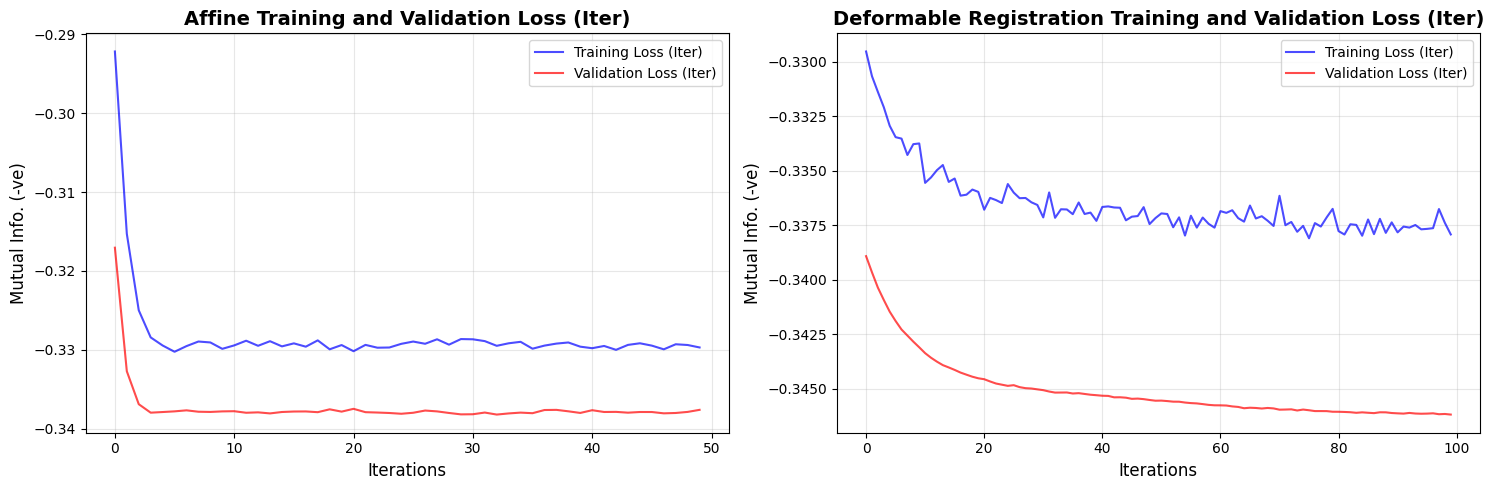

In [128]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training and Validation Loss (per iteration)
axes[0].plot(ckpt['train_loss']['affine'], label="Training Loss (Iter)", color="blue", alpha=0.7)
axes[0].plot(ckpt['val_loss']['affine'], label="Validation Loss (Iter)", color="red", alpha=0.7)
axes[0].set_xlabel(f"Iterations", fontsize=12)
axes[0].set_ylabel("Mutual Info. (-ve)", fontsize=12)
axes[0].set_title("Affine Training and Validation Loss (Iter)", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(ckpt['train_loss']['deform'], label="Training Loss (Iter)", color="blue", alpha=0.7)
axes[1].plot(ckpt['val_loss']['deform'], label="Validation Loss (Iter)", color="red", alpha=0.7)
axes[1].set_xlabel(f"Iterations", fontsize=12)
axes[1].set_ylabel("Mutual Info. (-ve)", fontsize=12)
axes[1].set_title("Deformable Registration Training and Validation Loss (Iter)", fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
